texte en gras

# Installation des bibliothèques

In [ ]:
!pip install yfinance pandas_datareader
!pip install matplotlib seaborn
!pip install

# Financial performance comparison 1

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Liste des entreprises (tickers Yahoo Finance pour CAC 40 luxe)
companies = {
    "LVMH": "MC.PA",
    "Kering": "KER.PA",
    "Hermes": "RMS.PA",
    "L'Oreal": "OR.PA",
    "Pernod Ricard": "RI.PA"
}

# Période à filtrer après récupération
start_year = 2021
end_year = 2024  # 2025 pas encore publié dans la plupart des cas

# Fonction pour extraire les données financières
def get_financial_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    try:
        income_stmt = ticker.financials.T     # Compte de résultat
        balance_sheet = ticker.balance_sheet.T  # Bilan
    except:
        return None, None
    return income_stmt, balance_sheet

# Initialisation des données
data = []

for company, ticker in companies.items():
    print(f"Récupération de {company}")
    income, balance = get_financial_data(ticker)

    if income is None or balance is None:
        print(f"Données manquantes pour {company}")
        continue

    for date in income.index:
        year = date.year
        if start_year <= year <= end_year:
            row = {
                "Company": company,
                "Year": year,
                "Revenue": income.loc[date].get("Total Revenue", None),
                "Net Income": income.loc[date].get("Net Income", None),
                "Equity": balance.loc[date].get("Total Stockholder Equity", None),
                "Assets": balance.loc[date].get("Total Assets", None),
                "Liabilities": balance.loc[date].get("Total Liabilities Net Minority Interest", None),
                "Current Assets": balance.loc[date].get("Current Assets", None),
                "Current Liabilities": balance.loc[date].get("Current Liabilities", None)
            }
            data.append(row)

# Créer un DataFrame
df = pd.DataFrame(data)

equity_data = {
    'LVMH': {
        2020: 38829000000,
        2021: 48909000000,
        2022: 56604000000,
        2023: 62701000000,
        2024: 69287000000
    },
    'Kering': {
        2021: 16251000000,
        2022: 15575000000,
        2023: 17328000000,
        2024: 17021000000
    },
    'Hermes': {
        2021: 9417000000,
        2022: 11922000000,
        2023: 14038000000,
        2024: 17330000000
    },
    "L'Oreal": {
        2021: 23593000000,
        2022: 27186000000,
        2023: 29082000000,
        2024: 33130000000
    },
    'Pernod Ricard': {
        2021: 14944000000,
        2022: 15717000000,
        2023: 16715000000,
        2024: 16797000000
    }
}

for index, row in df.iterrows():
    company = row['Company']
    year = row['Year']
    if pd.isna(row['Equity']):
        equity = equity_data.get(company, {}).get(year)
        if equity:
            df.at[index, 'Equity'] = equity

# Trier les lignes
df = df.sort_values(by=["Company", "Year"])

# Afficher les premières lignes
print("Aperçu des données corrigées :")
print(df.head())

# Calcul automatique des ratios financiers

# Création des colonnes ratios dans le DataFrame
df["ROE"] = df["Net Income"] / df["Equity"]
df["ROA"] = df["Net Income"] / df["Assets"]
df["Current Ratio"] = df["Current Assets"] / df["Current Liabilities"]
df["Debt to Equity"] = df["Liabilities"] / df["Equity"]
df["Net Profit Margin"] = df["Net Income"] / df["Revenue"]

# Format arrondi pour lisibilité
df["ROE"] = df["ROE"].round(3)
df["ROA"] = df["ROA"].round(3)
df["Current Ratio"] = df["Current Ratio"].round(2)
df["Debt to Equity"] = df["Debt to Equity"].round(2)
df["Net Profit Margin"] = df["Net Profit Margin"].round(3)

# Affichage final
print("\n Tableau des ratios calculés :")
print(df[["Company", "Year", "ROE", "ROA", "Current Ratio", "Debt to Equity", "Net Profit Margin"]])

# Evolution du ROE de LVMH
lvmh = df[df["Company"] == "LVMH"]

plt.figure(figsize=(8, 5))
sns.barplot(x=lvmh["Year"], y=lvmh["ROE"], color="royalblue")
plt.title("ROE de LVMH (2021–2024)")
plt.ylabel("ROE")
plt.xlabel("Année")
plt.ylim(0, lvmh["ROE"].max() * 1.2)
plt.grid(axis='y')
plt.show()


# 📊 Comparaison du ROE entre toutes les entreprises et années
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Year", y="ROE", hue="Company", palette="tab10")

plt.title("Comparaison du ROE (2021–2024) entre entreprises du CAC 40 - secteur luxe")
plt.ylabel("ROE")
plt.xlabel("Année")
plt.legend(title="Entreprise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Radar chart pour LVMH en 2023
lvmh_2023 = df[(df["Company"] == "LVMH") & (df["Year"] == 2023)].iloc[0]
labels = ["ROE", "ROA", "Current Ratio", "Debt to Equity", "Net Profit Margin"]
values = [lvmh_2023[label] for label in labels]

# Boucler le graphique
values += values[:1]
angles = np.linspace(0, 2 * np.pi, len(values))

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='darkorange', linewidth=2)
ax.fill(angles, values, color='orange', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Ratios financiers LVMH – Année 2023")
plt.show()

# Waterfall sur LVMH 2023
revenue = lvmh_2023["Revenue"]
net_income = lvmh_2023["Net Income"]
autres = revenue - net_income

steps = ["Chiffre d'affaires", "Charges totales estimées", "Résultat net"]
values = [revenue, -autres, net_income]
cumulative = [0, revenue, net_income]

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['steelblue', 'indianred', 'seagreen']
for i in range(len(values)):
    ax.bar(steps[i], values[i], bottom=cumulative[i] - values[i] if i != 0 else 0, color=colors[i])
    ax.text(i, cumulative[i], f"{values[i]:,.0f} €", ha='center', va='bottom')

plt.title("Waterfall – LVMH 2023")
plt.ylabel("Montant (€)")
plt.grid(axis='y')
plt.show()

def plot_line_comparison(df, ratio_name):
    """
    Affiche un graphique en ligne pour comparer un ratio
    entre plusieurs entreprises au fil des années.

    Paramètres :
    - df : DataFrame contenant les colonnes 'Company', 'Year', et le ratio.
    - ratio_name : Nom du ratio à tracer (ex: 'ROE', 'ROA', etc.)
    """
    if ratio_name not in df.columns:
        print(f"❌ Le ratio '{ratio_name}' n'existe pas dans le DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="Year", y=ratio_name, hue="Company", marker="o", linewidth=2.5)

    plt.title(f"Évolution du ratio {ratio_name} par entreprise (2021–2024)")
    plt.xlabel("Année")
    plt.ylabel(ratio_name)
    plt.grid(True)
    plt.legend(title="Entreprise", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_line_comparison(df, "ROE")
plot_line_comparison(df, "ROA")
plot_line_comparison(df, "Net Profit Margin")
plot_line_comparison(df, "Current Ratio")
plot_line_comparison(df, "Debt to Equity")

# Sauvegarder en CSV
df.to_csv("financial_data_luxury_cac40.csv", index=False)


Récupération de LVMH
Récupération de Kering
Récupération de Hermes
Récupération de L'Oreal
Récupération de Pernod Ricard


KeyError: 'Company'

# Financial performance comparison 2

In this section of the project, due to a bug with Yahoo Finance, we opted for an alternative approach to continue our analysis efficiently. We created an Excel file compiling the financial data of LVMH and its main competitors luxury sector companies listed on the CAC 40. The financial information was sourced from Refinitiv. Based on this structured dataset, we developed Python code to compute key financial ratios and visualize the results using various types of graphs.

          Company  Dates  Revenue (M€)  Net Income (M€)  Equity (M€)  \
0            LVMH   2021       64215.0          12036.0      48909.0   
1            LVMH   2022       79184.0          14084.0      56604.0   
2            LVMH   2023       86153.0          15174.0      62701.0   
3            LVMH   2024       84683.0          12550.0      69287.0   
4   Pernod Ricard   2021        8824.0           1305.0      15075.0   
5   Pernod Ricard   2022       10701.0           1996.0      16253.0   
6   Pernod Ricard   2023       12137.0           2262.0      16715.0   
7   Pernod Ricard   2024       11598.0           1476.0      16797.0   
8         L'Oreal   2021       32288.0           4597.1      25593.0   
9         L'Oreal   2022       38261.0           5706.6      27187.0   
10        L'Oreal   2023       41183.0           6184.0      29082.0   
11        L'Oreal   2024       43487.0           6408.7      33138.0   
12         Kering   2021       17645.2           3175.7      137

,Company,Dates,ROE (%),ROA (%),Net Profit Margin (%),Endettement (%),Current Ratio
0,LVMH,2021,24.608968,9.604903,18.743284,156.212558,1.225517
1,LVMH,2022,24.881634,10.460021,17.786421,137.873649,1.259867
2,LVMH,2023,24.200571,10.559940,17.612852,129.173378,1.318751
3,LVMH,2024,18.113066,8.412092,14.819976,115.321778,1.408802
4,Pernod Ricard,2021,8.656716,4.059477,14.789211,113.247098,2.425557
5,Pernod Ricard,2022,12.280810,5.542597,18.652462,121.571402,1.947929
6,Pernod Ricard,2023,13.532755,6.003822,18.637225,125.402333,1.731507
7,Pernod Ricard,2024,8.787283,3.766747,12.726332,133.285706,1.842476
8,L'Oreal,2021,17.962333,10.687699,14.237797,75.884031,0.728216
9,L'Oreal,2022,20.990179,12.182136,14.914926,72.306617,1.024052


✅ Financial ratios calculated successfully!

📊 Net Profit Margin (%) for 2024:
          Company  Net Profit Margin (%)
3            LVMH              14.819976
7   Pernod Ricard              12.726332
11        L'Oreal              14.737048
15         Kering               6.589508
19         Hermes              30.342782

📊 Debt Ratio (%) for 2024:
          Company  Endettement (%)
3            LVMH       115.321778
7   Pernod Ricard       133.285706
11        L'Oreal        70.058543
15         Kering       175.562619
19         Hermes        33.171801


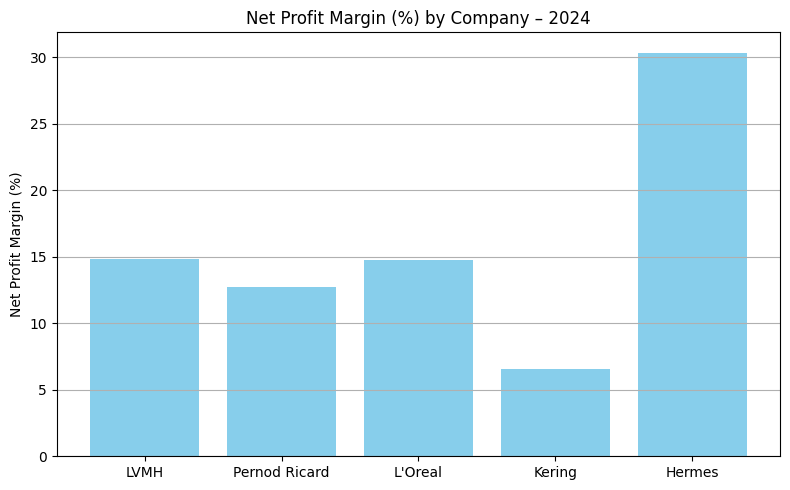

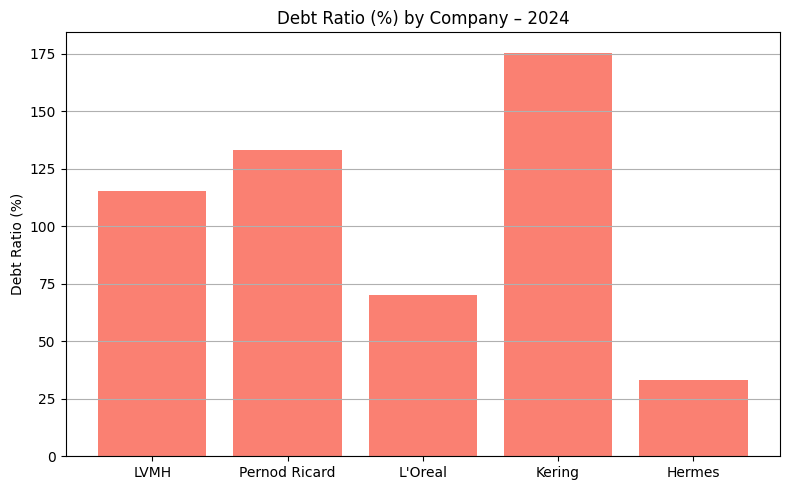

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload and load the Excel file
import pandas as pd
df=pd.read_excel(r'modele_donnees_financieres_luxe_2021_2024 - Copie.xlsx')
print(df)

# Step 2: Calculate financial ratios per row
def calculate_ratios(row):
    try:
        roe = (row['Net Income (M€)'] / row['Equity (M€)']) * 100
        roa = (row['Net Income (M€)'] / row['Assets (M€)']) * 100
        margin = (row['Net Income (M€)'] / row['Revenue (M€)']) * 100
        debt = (row['Liabilities (M€)'] / row['Equity (M€)']) * 100
        current_ratio = row['Current Assets (M€)'] / row['Current Liabilities (M€)']
        return pd.Series([roe, roa, margin, debt, current_ratio])
    except:
        return pd.Series([None]*5)

# Add new ratio columns to the DataFrame
df[['ROE (%)', 'ROA (%)', 'Net Profit Margin (%)', 'Endettement (%)', 'Current Ratio']] = df.apply(calculate_ratios, axis=1)

# Afficher les colonnes utiles dans un tableau
print("📊 Aperçu des ratios financiers calculés :")
display(df[['Company', 'Dates', 'ROE (%)', 'ROA (%)', 'Net Profit Margin (%)', 'Endettement (%)', 'Current Ratio']].head(10))

# Confirmation
print("✅ Financial ratios calculated successfully!\n")

# Step 3: Filter year 2024
df_2024 = df[df['Dates'] == 2024]

# Display Net Profit Margin 2024
print("📊 Net Profit Margin (%) for 2024:")
print(df_2024[['Company', 'Net Profit Margin (%)']])

# Display Endettement (%) 2024
print("\n📊 Debt Ratio (%) for 2024:")
print(df_2024[['Company', 'Endettement (%)']])

# Step 4: Bar plot - Net Profit Margin 2024
plt.figure(figsize=(8, 5))
plt.bar(df_2024['Company'], df_2024['Net Profit Margin (%)'], color='skyblue')
plt.title("Net Profit Margin (%) by Company – 2024")
plt.ylabel("Net Profit Margin (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Bar plot - Debt Ratio 2024
plt.figure(figsize=(8, 5))
plt.bar(df_2024['Company'], df_2024['Endettement (%)'], color='salmon')
plt.title("Debt Ratio (%) by Company – 2024")
plt.ylabel("Debt Ratio (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


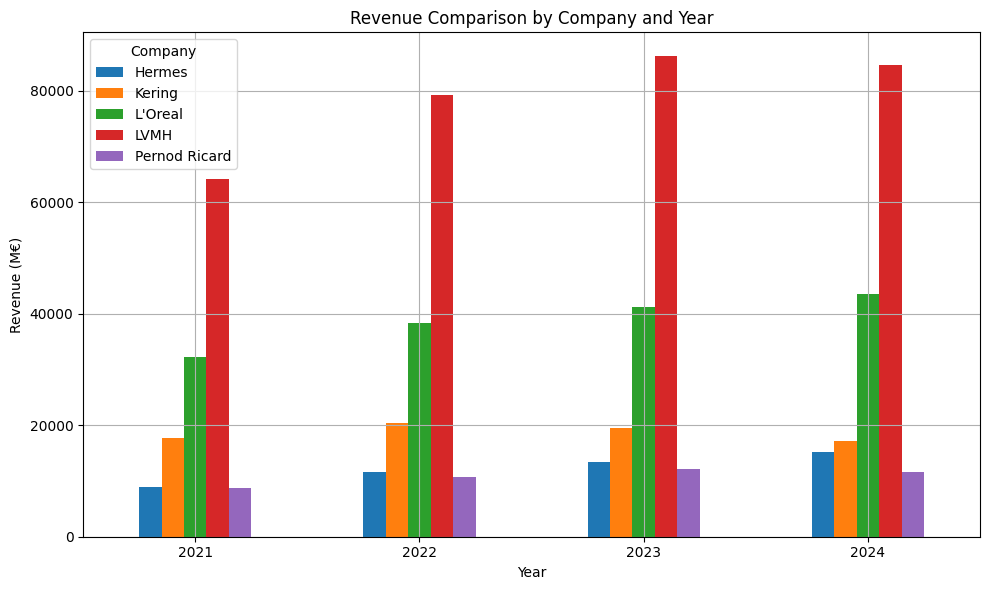

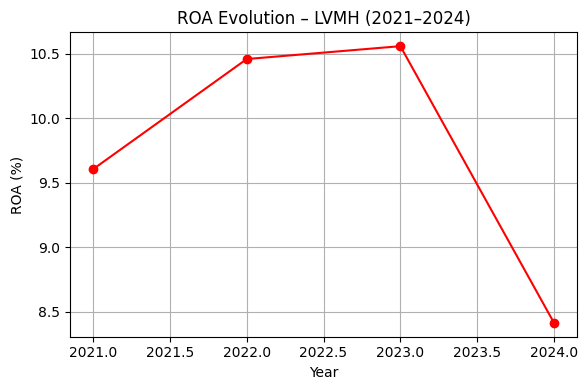

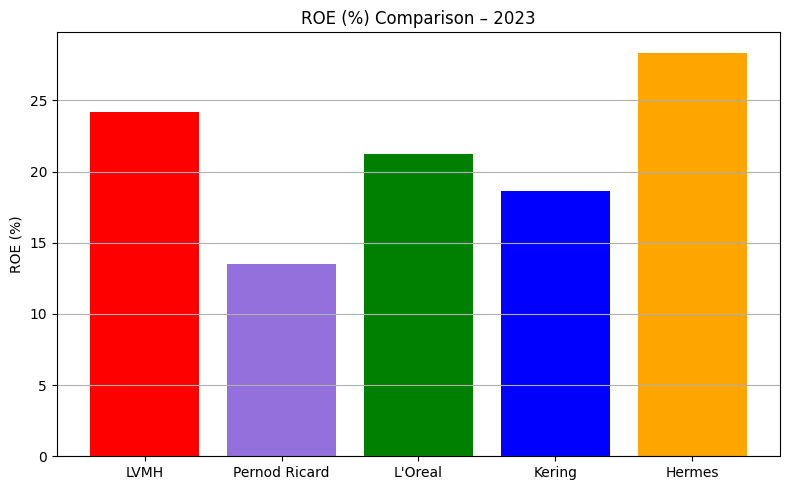

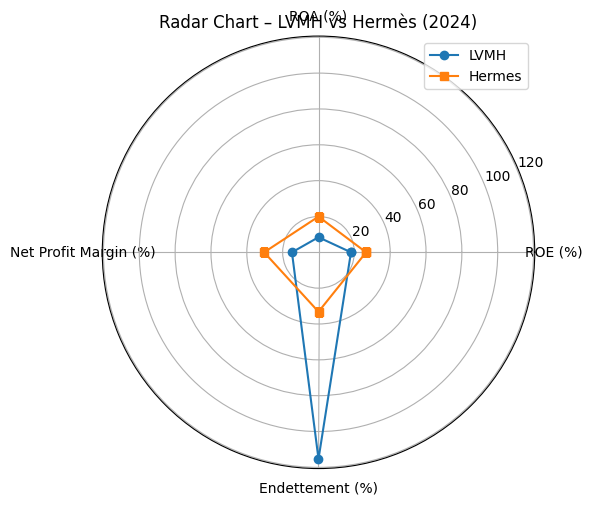

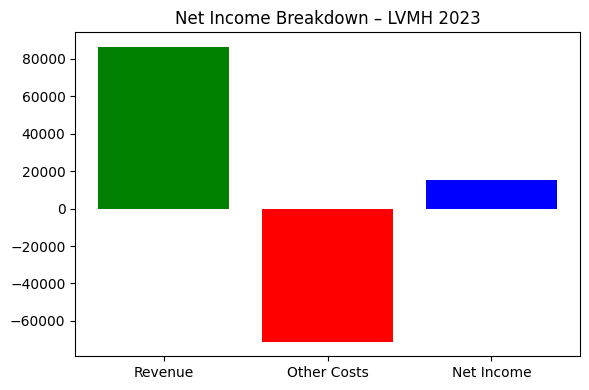

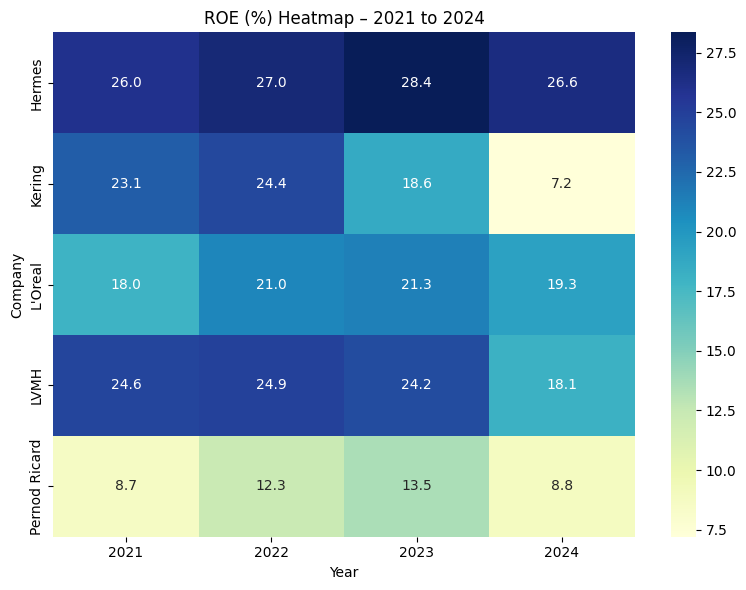

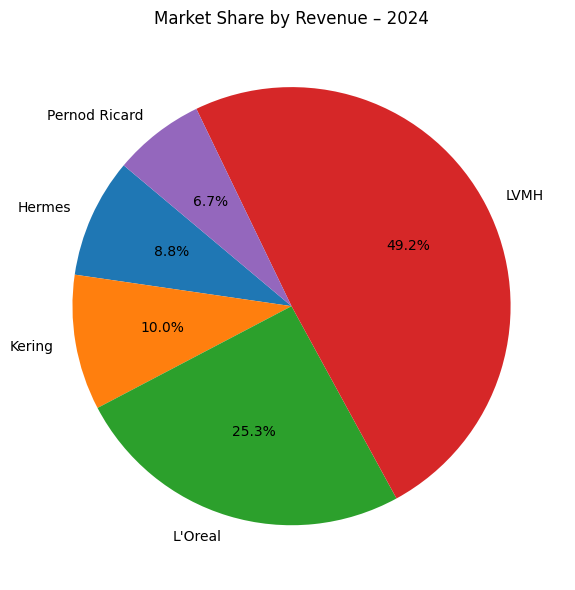

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Bar chart: Revenue by company and year
revenue_df = df.pivot(index='Dates', columns='Company', values='Revenue (M€)')
revenue_df.plot(kind='bar', figsize=(10, 6))
plt.title("Revenue Comparison by Company and Year")
plt.xlabel("Year")
plt.ylabel("Revenue (M€)")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Line chart: ROA of LVMH (2021–2024)
lvmh_roa = df[df['Company'] == 'LVMH'][['Dates', 'ROA (%)']].set_index('Dates')
plt.figure(figsize=(6, 4))
plt.plot(lvmh_roa.index, lvmh_roa['ROA (%)'], marker='o', color='red')
plt.title("ROA Evolution – LVMH (2021–2024)")
plt.xlabel("Year")
plt.ylabel("ROA (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Bar chart: ROE comparison in 2023
roe_2023 = df[df['Dates'] == 2023][['Company', 'ROE (%)']].set_index('Company')
colors = ['red', 'mediumpurple', 'green', 'blue', 'orange']
plt.figure(figsize=(8, 5))
plt.bar(roe_2023.index, roe_2023['ROE (%)'], color=colors)
plt.title("ROE (%) Comparison – 2023")
plt.ylabel("ROE (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 4. Radar chart: LVMH vs Hermès – 2024
labels = ['ROE (%)', 'ROA (%)', 'Net Profit Margin (%)', 'Endettement (%)']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

lvmh_2024 = df[(df['Company'] == 'LVMH') & (df['Dates'] == 2024)].iloc[0]
hermes_2024 = df[(df['Company'] == 'Hermes') & (df['Dates'] == 2024)].iloc[0]

values_lvmh = [lvmh_2024[label] for label in labels] + [lvmh_2024[labels[0]]]
values_hermes = [hermes_2024[label] for label in labels] + [hermes_2024[labels[0]]]

plt.figure(figsize=(6, 6))
plt.polar(angles, values_lvmh, label='LVMH', marker='o')
plt.polar(angles, values_hermes, label='Hermes', marker='s')
plt.xticks(angles[:-1], labels)
plt.title("Radar Chart – LVMH vs Hermès (2024)")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Waterfall: Net income construction for LVMH in 2023
revenue = df[(df['Company'] == 'LVMH') & (df['Dates'] == 2023)]['Revenue (M€)'].values[0]
net_income = df[(df['Company'] == 'LVMH') & (df['Dates'] == 2023)]['Net Income (M€)'].values[0]
other_costs = revenue - net_income

labels = ['Revenue', 'Other Costs', 'Net Income']
values = [revenue, -other_costs, net_income]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(values)), values, color=['green', 'red', 'blue'])
ax.set_xticks(range(len(values)))
ax.set_xticklabels(labels)
ax.set_title("Net Income Breakdown – LVMH 2023")
plt.tight_layout()
plt.show()

# 6. Heatmap: ROE over 4 years by company
roe_heatmap = df.pivot(index='Company', columns='Dates', values='ROE (%)')
plt.figure(figsize=(8, 6))
sns.heatmap(roe_heatmap, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title("ROE (%) Heatmap – 2021 to 2024")
plt.xlabel("Year")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

# 7. Pie chart: Revenue share by company in 2024
revenue_2024 = df[df['Dates'] == 2024][['Company', 'Revenue (M€)']].groupby('Company').sum()
plt.figure(figsize=(6, 6))
plt.pie(revenue_2024['Revenue (M€)'], labels=revenue_2024.index, autopct='%1.1f%%', startangle=140)
plt.title("Market Share by Revenue – 2024")
plt.tight_layout()
plt.show()


### Analysis

1. Revenue Comparison by Company and Year

This graph compares the annual sales of the 5 companies in the luxury goods sector.
    LVMH dominates in terms of revenues.
    L'Oréal remains the second-largest player.
    Most of these companies are growing steadily, with the exception of Kering, which is set to decline in 2024.

2. ROA Evolution – LVMH (2021–2024)

LVMH's Return on Assets increases until 2023, before falling in 2024.
This may reflect a fall in profitability or an increase in assets without an equivalent rise in net income.

3. ROE Comparison – 2023

Hermès is the best performer in terms of ROE (> 28%) in 2023.
LVMH and L'Oréal follow.
Pernod Ricard reste en retrait.

4. Radar Chart – LVMH vs Hermès (2024)

Hermès performs better on net margin and ROE.
LVMH has a much higher level of debt, which may indicate high financial leverage.

5. Net Income Breakdown – LVMH 2023

This waterfall chart shows :
High revenues (> 85,000 M€)
Very high "other costs"
Net income much lower than sales

6. Heatmap – ROE 2021 à 2024

Hermès and LVMH maintain very high and stable profitability
Kering falls sharply in 2024
Pernod Ricard remains weak but grows slightly until 2023

7. Market Share by Revenue – 2024

LVMH accounts for almost 50% of total sales.
L'Oréal represents around 25%.
The other companies share the remaining 25%.

# CORRELATION

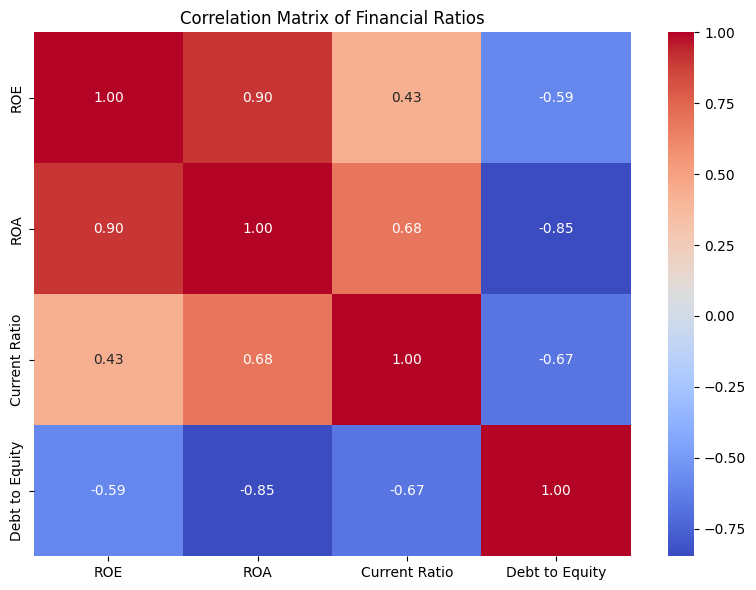

Correlation matrix:
                     ROE       ROA  Current Ratio  Debt to Equity
ROE             1.000000  0.904993       0.434116       -0.592246
ROA             0.904993  1.000000       0.684755       -0.847230
Current Ratio   0.434116  0.684755       1.000000       -0.671542
Debt to Equity -0.592246 -0.847230      -0.671542        1.000000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Financial ratio data for LVMH and competitors
data = {
    "Company": [
        "Hermes", "Hermes", "Hermes", "Hermes",
        "Kering", "Kering", "Kering", "Kering",
        "L'Oreal", "L'Oreal", "L'Oreal", "L'Oreal",
        "LVMH", "LVMH", "LVMH", "LVMH",
        "Pernod Ricard", "Pernod Ricard", "Pernod Ricard", "Pernod Ricard"
    ],
    "Year": [2021, 2022, 2023, 2024] * 5,
    "ROE": [0.259637, 0.282419, 0.307095, 0.265069,
            0.195434, 0.232039, 0.178139, 0.066565,
            0.19485, 0.20991, 0.21264, 0.193441,
            0.24609, 0.248816, 0.242006, 0.184011,
            0.087336, 0.126995, 0.153328, 0.087873],
    "ROA": [0.177, 0.193, 0.211, 0.199,
            0.102, 0.106, 0.072, 0.026,
            0.107, 0.122, 0.119, 0.114,
            0.106, 0.105, 0.106, 0.081,
            0.041, 0.055, 0.060, 0.038],
    "Current Ratio": [3.43, 3.94, 4.40, 4.26,
                      1.30, 1.37, 1.28, 1.21,
                      0.73, 1.00, 1.10, 1.13,
                      1.23, 1.26, 1.32, 1.41,
                      2.45, 1.95, 1.73, 1.86],
    "Debt to Equity": [0.470851, 0.41956, 0.373415, 0.331795,
                       1.066519, 1.230048, 1.463358, 1.622466,
                       0.823195, 0.722308, 0.783079, 0.700743,
                       1.562126, 1.378736, 1.291734, 1.153218,
                       1.142398, 1.257174, 1.254029, 1.332857]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Select only ratio columns
ratios_df = df[["ROE", "ROA", "Current Ratio", "Debt to Equity"]]

# Compute correlation matrix
correlation_matrix = ratios_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Financial Ratios")
plt.tight_layout()
plt.show()

# Print the matrix
print("Correlation matrix:")
print(correlation_matrix)


# Stock Market Performance

In this complementary section of our financial analysis, we focus on evaluating the stock market performance of LVMH and its main competitors. Specifically, we study the evolution of their stock prices over the period from January 1, 2021, to January 1, 2025. The objective is to calculate both annual and cumulative returns, allowing us to assess how these companies have performed over time in terms of shareholder value. To put these results into perspective, we compare them to a relevant market benchmark the CAC 40 index.

     Date   LVMH  Kering  Hermes  Pernod Ricard  L'Oreal   CAC 40
0   44197  49.71  541.60   842.6         155.70   290.10  5399.21
1   44228  51.64  524.90   923.2         157.35   302.80  5703.22
2   44256  54.88  588.60   944.0         160.05   326.80  6067.23
3   44287  54.28  666.50  1044.0         170.70   341.65  6269.48
4   44317  53.69  748.30  1152.5         180.15   368.30  6447.17
5   44348  56.89  737.00  1228.5         187.20   375.80  6507.83
6   44378  59.25  756.20  1289.0         186.10   385.90  6612.76
7   44409  61.95  674.00  1244.5         177.95   396.30  6680.18
8   44440  61.87  616.00  1196.5         190.70   356.85  6520.01
9   44470  72.74  648.20  1370.5         198.70   394.95  6830.34
10  44501  61.31  681.40  1653.0         202.50   397.50  6721.16
11  44531  62.51  706.90  1536.0         211.50   416.95  7153.03
12  44562  56.47  656.30  1318.5         189.00   376.85  6999.20
13  44593  48.21  637.10  1242.0         195.65   355.00  6658.83
14  44621 

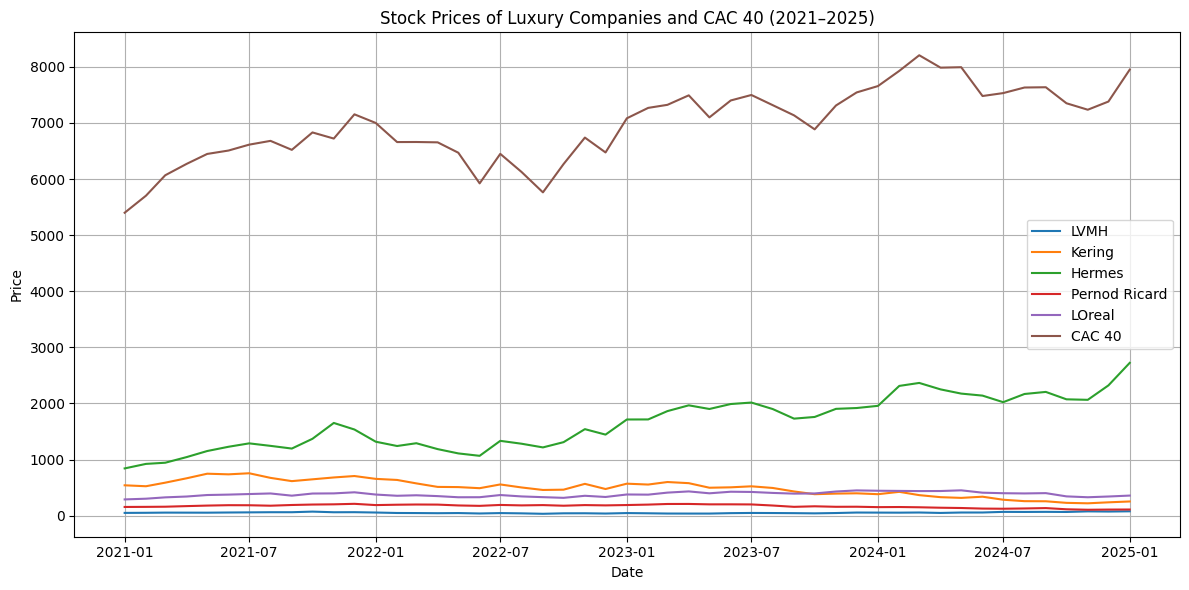

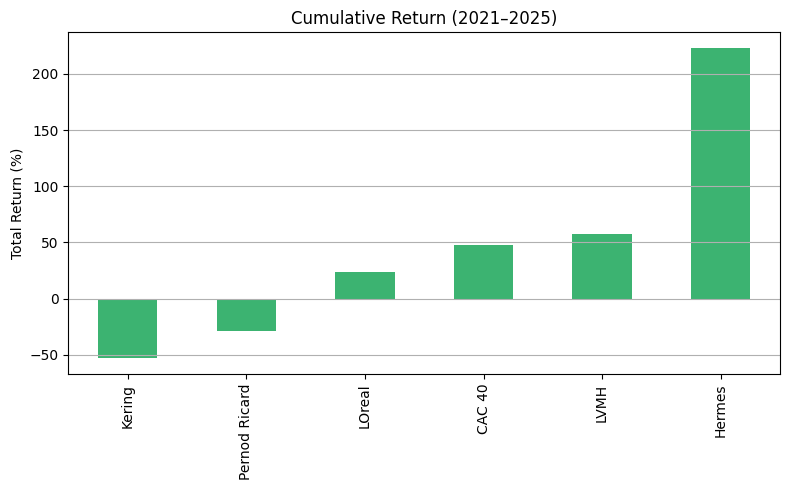

<ipython-input-5-c991feb82edd>:42: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').last()


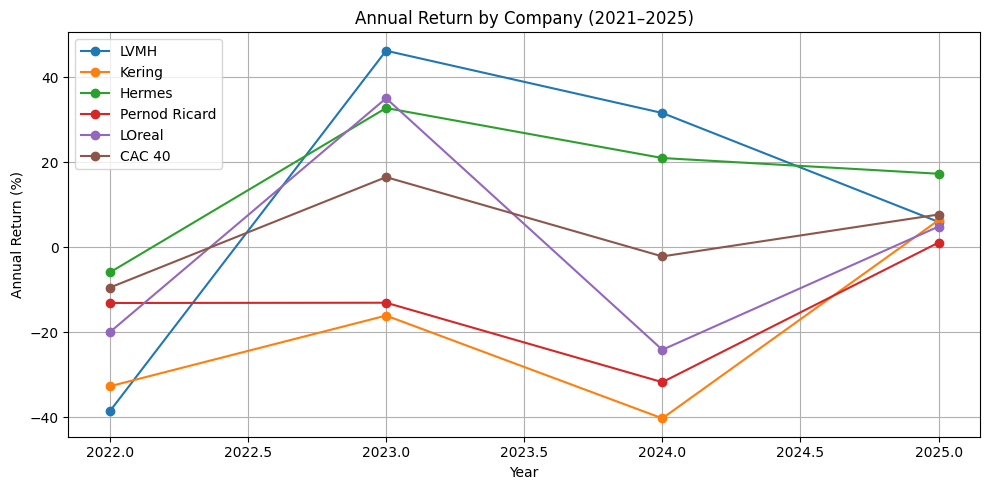

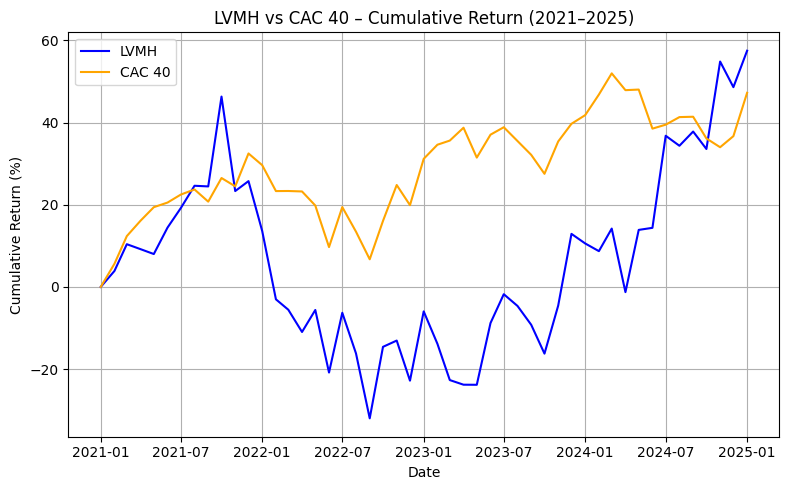

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Upload Excel file
import pandas as pd
df=pd.read_excel(r'Stock Market Data cac 40.xlsx')
print(df)

# Clean column names and convert date
df.columns = df.columns.str.replace("'", "")  # fix L'Oreal → LOreal
df.rename(columns={"LOreal": "LOreal"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], origin='1899-12-30', unit='D')
df.set_index('Date', inplace=True)

# 1. Plot stock prices
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.title("Stock Prices of Luxury Companies and CAC 40 (2021–2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Cumulative return (2021–2025)
returns = df / df.iloc[0] - 1  # (P / P0) - 1
returns_cum = returns.iloc[-1] * 100

plt.figure(figsize=(8, 5))
returns_cum.sort_values().plot(kind='bar', color='mediumseagreen')
plt.title("Cumulative Return (2021–2025)")
plt.ylabel("Total Return (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 3. Annual returns
df_yearly = df.resample('Y').last()
annual_returns = df_yearly.pct_change().dropna() * 100

plt.figure(figsize=(10, 5))
for company in annual_returns.columns:
    plt.plot(annual_returns.index.year, annual_returns[company], marker='o', label=company)
plt.title("Annual Return by Company (2021–2025)")
plt.xlabel("Year")
plt.ylabel("Annual Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Compare LVMH vs CAC 40
lvmh_returns = (df['LVMH'] / df['LVMH'].iloc[0] - 1) * 100
cac_returns = (df['CAC 40'] / df['CAC 40'].iloc[0] - 1) * 100

plt.figure(figsize=(8, 5))
plt.plot(df.index, lvmh_returns, label='LVMH', color='blue')
plt.plot(df.index, cac_returns, label='CAC 40', color='orange')
plt.title("LVMH vs CAC 40 – Cumulative Return (2021–2025)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Analysis

1. Stock Prices of Luxury Companies and CAC 40 (2021–2025)

The graph shows the absolute evolution of stock prices over time.
Hermès and L'Oréal show strong upward trends.
The CAC 40 index climbs steadily, offering a useful benchmark.
Kering underperforms, with visible stagnation or decline.

2. Cumulative Return (2021–2025)

Hermès leads with an impressive cumulative return of over +200%.
LVMH and CAC 40 perform moderately well (positive return).
Kering and Pernod Ricard have negative total returns, indicating value destruction.

3. Annual Return by Company (2021–2025)

The chart shows yearly volatility in returns.
Most companies had strong growth in 2023, followed by a general decline in 2024.
Kering showed repeated underperformance, especially in 2022 and 2024.

4. LVMH vs CAC 40 – Cumulative Return (2021–2025)

LVMH initially follows the CAC 40, then diverges downward during 2022–2023.
From mid-2024, LVMH regains strength, ending above the benchmark.
This comparison shows periods of underperformance and outperformance.